In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project`").getOrCreate()

In [2]:
spark

In [3]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.functions import year,month
from pyspark.sql.functions import col

In [4]:
pd.options.display.max_colwidth = 100

# import review dataset
reviews = spark.read.parquet("s3://amazon-reviews-pds/parquet/")

In [5]:
reviews.count()

160796570

In [6]:
reviews.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)



In [7]:
country = list(reviews.select('marketplace').distinct().toPandas()['marketplace'])
print('US', reviews.filter("marketplace = 'US'").count())
print('DE', reviews.filter("marketplace = 'DE'").count())
print('FR', reviews.filter("marketplace = 'FR'").count())
print('UK', reviews.filter("marketplace = 'UK'").count())
print('JP', reviews.filter("marketplace = 'JP'").count())

US 157893444
DE 679121
FR 254080
UK 1707494
JP 262431


In [8]:
reviews.select('product_category').distinct().count()

43

In [9]:
reviews.select('product_category').distinct().show(43)

+--------------------+
|    product_category|
+--------------------+
|                  PC|
|             Kitchen|
|                Home|
|            Wireless|
|               Video|
| Digital_Video_Games|
|Digital_Video_Dow...|
|             Luggage|
|              Sports|
|         Video_Games|
|  Mobile_Electronics|
|  Home_Entertainment|
|Digital_Ebook_Pur...|
|                Baby|
|             Apparel|
|    Major_Appliances|
|             Grocery|
|               Tools|
|         Electronics|
|            Outdoors|
|     Lawn_and_Garden|
|    Home_Improvement|
|        Pet_Products|
|          Automotive|
| Musical_Instruments|
|               Books|
|    Digital_Software|
|Health_&_Personal...|
|               Music|
|           Furniture|
|Personal_Care_App...|
|            Software|
|         Mobile_Apps|
|Digital_Music_Pur...|
|              Camera|
|               Shoes|
|     Office_Products|
|           Gift_Card|
|             Jewelry|
|             Watches|
|          

In [10]:
# select review for only US market
us_reviews = reviews.filter("marketplace = 'US'").cache()
# register for US market reviews' sql table
us_reviews.createOrReplaceTempView('ustbl')
# check the row number of US market reviews
spark.sql("""select count(*) from ustbl""").show()

+---------+
| count(1)|
+---------+
|157893444|
+---------+



In [11]:
us_reviews = us_reviews.withColumn("month",month(col("review_date")))

In [12]:
# count review amout by year and month
us_reviews_count = us_reviews.groupBy("year","month").agg(F.count("*").alias("count")).orderBy("year","month").toPandas()
us_reviews_count['year-month'] = pd.to_datetime(us_reviews_count[['year', 'month']].assign(Day=1))

In [13]:
ten_year_reviews = us_reviews_count[(us_reviews_count["year"]>= 2006)&(us_reviews_count["year"]<= 2015)]

In [14]:
ten_year_reviews.head(10)

,year,month,count,year-month
125,2006,1,130658,2006-01-01
126,2006,2,133788,2006-02-01
127,2006,3,164052,2006-03-01
128,2006,4,61715,2006-04-01
129,2006,5,104536,2006-05-01
130,2006,6,112454,2006-06-01
131,2006,7,132885,2006-07-01
132,2006,8,131971,2006-08-01
133,2006,9,82098,2006-09-01
134,2006,10,83790,2006-10-01


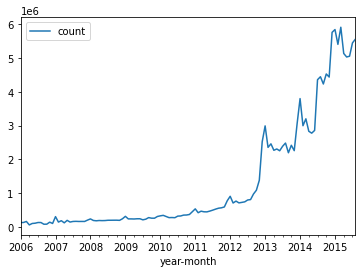

In [15]:
import matplotlib.pyplot as plt

ax = plt.gca()

ten_year_reviews.plot(kind='line',x='year-month',y='count',ax=ax)

plt.show()

In [ ]:
#varified puchase and unvarified purchase

In [ ]:
# count total review and average rating for verified purchase and non-verified pruchase
verified_rating = spark.sql("""select verified_purchase, avg(star_rating), count(*) as count
from ustbl
where year > 2005
group by verified_purchase
order by count
""").toPandas()

In [ ]:
verified_rating

In [ ]:
# bar plot
verified_rating.plot(kind='bar',x='verified_purchase',y='count')

In [ ]:
#purchase review

In [ ]:
# aggreagate vine_purchase
us_reviews_vine = us_reviews.groupBy("year","month","vine").agg(F.count("*").alias("vcount")).orderBy("year","month","vine").toPandas()

In [ ]:
# count total vine purchase reviews by month and year
vine_review = us_reviews_vine.groupby(["year", "month"], sort=False)["vcount"].sum().reset_index(name ='Total_Amount')

In [ ]:
# merge datasets
vine_total = pd.merge(us_reviews_vine, vine_review, on=['year', 'month'], how='inner')

In [ ]:
# calculate the percentage of vine purchase reviews and create year-month column
vine_total['vine_percentage'] = vine_total.apply (lambda row: row.vcount/row.Total_Amount, axis=1)
vine_total['year-month'] = pd.to_datetime(vine_total[['year', 'month']].assign(Day=1))

In [ ]:
# subset vine purchase for 2006-2015
vine_total_Y = vine_total[(vine_total["year"]>= 2006)&(vine_total["year"]<= 2015)&(vine_total["vine"] == "Y")]

In [ ]:
# gca stands for 'get current axis'
ax = plt.gca()

vine_total_Y.plot(kind='line',x='year-month',y='Total_Amount',ax=ax)

plt.show()

In [ ]:
# Vine Purchase and Non-vine Purchase

In [ ]:
# count total review and average rating for vine purchase and non-vine pruchase
vine_rating = spark.sql("""select vine, avg(star_rating), count(*) as count
from ustbl
where year > 2005
group by vine
order by count
""").toPandas()

In [ ]:
vine_rating

In [ ]:
# bar plot
vine_rating.plot(kind='bar',x='vine',y='count')

In [ ]:
# Count reviews by category
top_review = us_reviews.filter('year > 2005').groupBy("product_category").count().sort(col("count").desc()).toPandas()

In [ ]:
# find top 10 category
top10_category_review = top_review.head(10)

In [ ]:
top10_category_review

In [ ]:
# bar plot for top 10
top10_category_review.plot(kind='bar',x='product_category',y='count')